In [7]:
include("optimization_library.jl");
include("mplstyle.jl");

In [8]:
function PlotFunction(f, x0, x1, label = "f(x)", color = "blue")
    # create a number of x-values for which the function should be evaluated
    x_plot = range(x0, x1, length = 100)
    # evaluate the function for each point and write it to an array
    f_plot = [f(x) for x = x_plot]
    # do the same for the derivative
    
    # plot the function
    plot(x_plot,f_plot,color = color,label = label)
    
    
    xlabel("x")
    xlabel("y")
    
    # Some axis formatting
    ax = gca()
    # plot the legend
    ax.legend(loc = "upper left");
end

PlotFunction (generic function with 3 methods)

# Exercise 5.3

In [9]:
# g: Inequality constraint g(x) < 0
# dg: Gradient of the inequality constraint
# Hg: Hessian of the inequality constraint
function log_barrier(g, dg, Hg)
# ===============================================================================
    # Implement the log barrier function b(x) (without 1/t scaling factor) for the constraint function g(x). 
    # We could accidentally cross the barrier during descent steps. Return Inf when the barrier is crossed.
    b(x) = g(x) > 0 ? Inf : -log(-g(x))
    # Implement the gradient db(x) and hessian Hb(x) of the log barrier function.
    db(x) = -dg(x) / g(x)
    Hb(x) = ((dg(x) * dg(x)') / (g(x))^2) - (Hg(x) / g(x))
# ===============================================================================
    return b,db,Hb
end


# Interior Point Method in combination with log barrier and the Newton Method
# f: Objective function
# df: Gradient vector of the objective function
# Hf: Hessian matrix of the objective function
# x0: Initial point. Must be an interior point of the feasible set
# g: Array of inequality constraints g_i(x) < 0
# dg: Array with the gradient of the inequality constraints
# Hg: Array with the Hessian of the inequality constraints
# initial_barrier: initial scaling of barrier function
# barrier_increase: Factor by how much to increase the barrier in every outer iteration
# maxiters: maximum number of outer iterations
# inner_maxiters: maximum number of inner iterations (within descent method)
# ls: Use linesearch?
# eps: Stopping criterion

function ipm(f, df, Hf, x0; g=[], dg=[], Hg=[],
             initial_barrier = 1.0, barrier_increase = 2.0,
             maxiters=100, inner_maxiters=100,
             ls=true, eps=0.0001)

    glen = length(g) # number of constraints
    barr = Vector(undef, glen) # vector storing barrier functions of all constraints g_j(x) < 0
    dbarr = Vector(undef, glen) # vector storing gradients of barrier functions of all constraints g_j(x) < 0
    Hbarr = Vector(undef, glen) # vector storing hessian matricies of barrier functions of all constraints g_j(x) < 0
# ===============================================================================
    # 1. Fill barr, dbarr and Hbarr
    
    for i in 1:glen
        barr[i],dbarr[i],Hbarr[i] = log_barrier(g[i], dg[i], Hg[i])
    end

    # 2. Extend f, with the log barrier scaled by 1/t. Implement also the gradient and Hessian of the extended objective
    # function. Use closure functions.
    t = initial_barrier
    ftilde(x)  = f(x)  + sum([bb(x) for bb in barr]) / t
    dftilde(x) = df(x) + sum([dbb(x) for dbb in dbarr]) / t
    Hftilde(x) = Hf(x) + sum([Hbb(x) for Hbb in Hbarr]) / t
    
    # 3. Solve with the Newton Method and increasingly tighten the barrier using barrier_increase.
    # Break the outer iteration if the solution does not change any more within the required precision ε
    x = copy(x0)
    trace = [x; ftilde(x)] # or trace = [x; f(x)]
    for _ = 1:maxiters # Outer Iteration
        x,_ = newton_descent(ftilde, dftilde, Hftilde, x;
                             ls=ls, eps=eps, maxiters=inner_maxiters) # Inner Iteration
        trace = hcat(trace, [x; ftilde(x)]) # or trace = hcat(trace, [x; f(x)])
        if LA.norm(trace[1:end-1,end-1] - x) < eps
            break
        end
        t *= barrier_increase
    end
# ===============================================================================
    return x,trace
end

ipm (generic function with 1 method)

## Test the implementation of ipm

Take the following optimimization problem:

\begin{align}
\text{minimize}\quad &f(x) = x^2 + 1\\
\text{subject to} \quad &x \in [2,4]
\end{align}



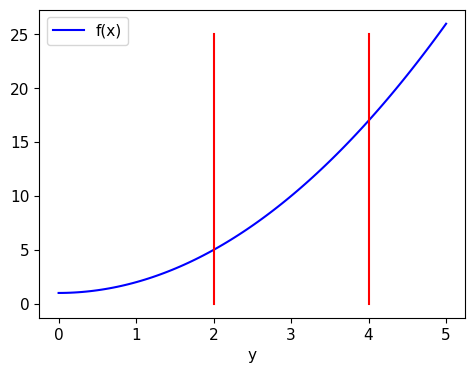

In [10]:
f(x) = x^2 + 1

PlotFunction(f, 0, 5)
plot((2,2),(0,25), color = "red")
plot((4,4),(0,25), color = "red");

Bringing the problem to the canonical form:

\begin{align}
\text{minimize}\quad &f(x) = x^2 + 1\\
\text{subject to} \quad &2 - x \leq 0\\
& x-4 \leq 0
\end{align}

In [11]:
f(x) = sum(x.^2 .+ 1)
df(x) = 2 * x
Hf(x) = ones(1,1)*2

g1(x) = sum(2 .-x)
dg1(x) = [-1]
Hg1(x) = zeros(1,1)

g2(x) = sum(x .-4)
dg2(x) = [1]
Hg2(x) = zeros(1,1)


# ===============================================================================
# Check your implementation of the interior point method for the problem given above.
x_best, trace_simple = ipm(f, df, Hf, [3.9]; g=[g1,g2], dg=[dg1,dg2], Hg=[Hg1,Hg2], initial_barrier = 1.0, barrier_increase = 2.0,
             maxiters=100, inner_maxiters=100,
             ls=true, eps=0.0001)

@assert (x_best[1] - 2) < 0.001
# ===============================================================================

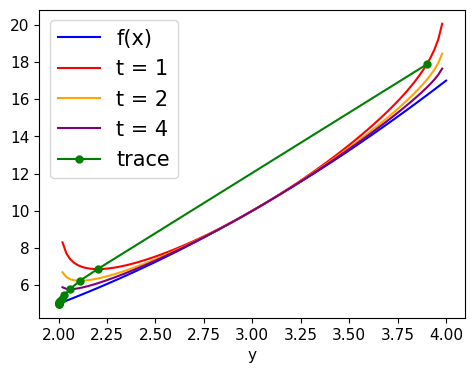

PyObject <matplotlib.legend.Legend object at 0x000001FD179CE2A0>

In [12]:
# define f(x) + barrier for plotting
function bf(t)
    function barrier(x)
        return x^2 + 1 - 1/t * (log(x-2) + log(4-x))
    end
end

# plot original function f(x)
PlotFunction(f, 2, 4)
# plot f(x) + barrier for different values of t
PlotFunction(bf(1), 2, 4, "t = 1", "red")
PlotFunction(bf(2), 2, 4, "t = 2", "orange")
PlotFunction(bf(4), 2, 4, "t = 4", "purple")
# plot trace of interior point method
plot(trace_simple[1,:], trace_simple[2,:], label = "trace", marker = "o", markersize = 5, color = "green")
legend(loc = "upper left", fontsize = 15)

# Exercise 5.4: McDonalds Diet

We would like to eat at McDonalds and fill our daily requirement of nutrients. However, in doing so we would like to minimize the amount of calories we eat.

In analogy to the Stiegler's diet we can formulate the problem in the following way:
\begin{align}
\text{minimize}\qquad & c^\top x\\
\text{subject to} \qquad & a_i^\top x \geq b_i\\
\qquad & x_k \geq 0, \quad k = 1,\dots n_{food}
\end{align}
with the vector $x$ storing the amount for each product, the vector $c$ storing the amount of calories for each product, the vectors $a_i$ storing the amount of nutrient $i$ for each food and $b_i$ the minimum daily requirement for nutrient $i$.

In [13]:
import DelimitedFiles
using DataFrames
DF = DelimitedFiles;

In [14]:
# Load the datasets

# daily requirement on nutrients
nutr_ideal = DF.readdlm("nutr_ideal.dat")
nutrients = nutr_ideal[1,:]
nutrients_required = nutr_ideal[2,:]

# Dataset of Mc Donalds Products and corresponding calories and nutrients
diet_data = DF.readdlm("McDonaldsData.csv")

# name of products
products = diet_data[2:end,1]

# matrix with nutrients per food, size = (length(products),length(nutrients))
nutrients_provided = Matrix{Float64}(diet_data[2:end,4:end])

Nproducts = length(products)
Nnutrients = length(nutrients);

# vector of calories for each food, size = (Nproducts)
cal = diet_data[2:end,2];

In [9]:
using PrettyTables

# Assuming diet_data is your data matrix and the first row contains column names
pretty_table(diet_data[2:end, :], header=diet_data[1, :], display_size=(20, 120))


┌──────────────────────────────────────────────────────────────────────────────┬──────┬────────┬─────┬────────┬──────┬────────┬───────┬─────────┬──────┬──────┬─────────┬──────┐
│                                                                         Food │  Cal │ CalFat │ Fat │ SatFat │ Chol │ Sodium │ Carbo │ Protein │ VitA │ VitC │ Calcium │ Iron │
├──────────────────────────────────────────────────────────────────────────────┼──────┼────────┼─────┼────────┼──────┼────────┼───────┼─────────┼──────┼──────┼─────────┼──────┤
│                                        1%_Low_Fat_Milk_Jug 1_carton_(236_ml) │  100 │     20 │   2 │      1 │   10 │    125 │    12 │       8 │   10 │    4 │      30 │    0 │
│                                                   Apple_Slices 1.2_oz_(34_g) │   15 │      0 │   0 │      0 │    0 │      0 │     4 │       0 │    0 │  160 │       2 │    0 │
│                                              BBQ_Ranch_Burger 4.1_oz_(116_g) │  350 │    140 │  16 │      6 │   4

Canonical form of optimization problem:
\begin{align}
\text{minimize}\qquad & cal^\top x\\
\text{subject to} \qquad & b_i - a_i^\top x \leq 0\\
\qquad & - x_k \leq 0, \quad k = 1,\dots n_{food}
\end{align}

In [10]:
# Create vectors that store the functions, gradients and hessian matrices for all constraints
c = Vector(undef, Nnutrients+Nproducts)
dc = Vector(undef, Nnutrients+Nproducts)
Hc = Vector(undef, Nnutrients+Nproducts)

# ===============================================================================
# Fill the vectors c, dc and Hc
# Mind that you have to bring the optimization problem to the canonical form (g_j(x) < 0) in order to be able to 
# use the implemented interior point method
# Hint: Each element of the vectors is a function. You might want to use anonymous functions here.
for i in 1:Nnutrients
    c[i] = x -> nutrients_required[i] - sum(nutrients_provided[:,i].*x) 
    # or c[i] = function (x) nutrients_required[i] - sum(nutrients_provided[:,i].*x) end
    dc[i] = x -> -nutrients_provided[:,i]
    Hc[i] = x -> zeros(Nproducts, Nproducts)
end

for i in 1:Nproducts # allow only positive quantities for the products
    c[Nnutrients+i] = x -> -x[i]
    dc[Nnutrients+i] = x -> begin d = zeros(Nproducts); d[i] = -1; return d end
    Hc[Nnutrients+i] = x -> zeros(Nproducts, Nproducts)
end
# ===============================================================================

In [11]:
# ===============================================================================
# Implement the objective function, its gradient and Hessian
f(x) = cal' * x # or LA.dot(cal,x)
df(x) = cal
Hf(x) = zeros(Nproducts, Nproducts)
# ===============================================================================

Hf (generic function with 1 method)

## This block takes a long time to run. 
1. So either don't run this cell during the live session and run directly the next cell
2. Or directly run the next cell to load the results


In [12]:
# # intialize starting point with large values in order to make sure to be within the feasible set
# x0 = 100000*ones(Nproducts);

# # Compute the solution
# amount, trace = ipm(f, df, Hf,x0; g=c, dg=dc, Hg=Hc, initial_barrier = 1.0, barrier_increase = 2.0,
#              maxiters=100, inner_maxiters=100,
#              ls=true, eps=0.0001);
# println("Number of outer iterations: ", size(trace,2))

# ##
# open("McDonalds_results.csv", "w") do io
#     DF.writedlm(io, [vcat(amount, zeros(1)) trace], ',')
# end

## Run this cell to directly load the results

In [13]:
# Read the CSV file
results_data = DF.readdlm("McDonalds_results.csv", ',')
amount = results_data[1:end-1, 1];

In [14]:
# Print the solutions
solutions = Vector{Int}()


for i in 1:Nproducts
    if amount[i] > 0.0001
        append!(solutions,i)
    end
end

println("Total Calories: \t\t", round(f(amount),digits = 2))
ttable = hcat(products[solutions],round.(amount[solutions],digits = 2))
pretty_table(ttable, header = ["Product", "Amount"], display_size = (20,120))

Total Calories: 		1833.93
┌───────────────────────────────────────────────────────────────────────┬────────┐
│                                                               Product │ Amount │
├───────────────────────────────────────────────────────────────────────┼────────┤
│                                        Coffee_Cream 0.4_fl_oz_(11_ml) │   0.92 │
│                                      Hot_Habanero_Sauce 22_oz_(0.8_g) │   4.92 │
│ Iced_Coffee_with_Sugar_Free_French_Vanilla_Syrup_(Large) 32_fl_oz_cup │   0.69 │
│                                           Ketchup_Packet 1_pkg_(10_g) │  51.08 │
│                                           Latte_(Small)_ 12_fl_oz_cup │   0.82 │
│                                              Side_Salad 3.1_oz_(87_g) │  19.26 │
│                                   Steak_&_Egg_McMuffin 6.5_oz_(184_g) │   0.66 │
└───────────────────────────────────────────────────────────────────────┴────────┘


In [15]:
# Check if requirements are fulfilled
ttable = hcat(nutrients,nutrients_required)
provided_nutrients = [sum(nutrients_provided[:,i].*amount[:]) for i in 1:Nnutrients]
ttable = hcat(ttable, provided_nutrients);
header = ["Nutrient", "Required", "provided"]
pretty_table(ttable, header=header)

┌────────────┬──────────┬──────────┐
│   Nutrient │ Required │ provided │
├────────────┼──────────┼──────────┤
│     Fat[g] │       65 │     65.0 │
│  SatFat[g] │       20 │     20.0 │
│   Chol[mg] │      300 │    300.0 │
│ Sodium[mg] │     2400 │  7012.07 │
│   Carbo[g] │      300 │    300.0 │
│ Protein[g] │       50 │     50.0 │
│    VitA[%] │      100 │  987.854 │
│    VitC[%] │      100 │  584.913 │
│ Calcium[%] │      100 │    100.0 │
│    Iron[%] │      100 │    100.0 │
└────────────┴──────────┴──────────┘


In [16]:
# Check on nutrients in each product that is part of the solution
ttable = hcat(round.(amount[solutions], digits = 1),first.(products[solutions], 15))
ttable = hcat(ttable, round.(cal[solutions].*amount[solutions], digits = 1))
ttable = hcat(ttable,round.(nutrients_provided[solutions,:].*amount[solutions], digits = 1))
header = ["Amount", "Product", "Calories", "Fat", "SatFat", "Chol", "Sodium", "Carbo", "Protein", "VitA", "VitC", "Calcium", "Iron"];
pretty_table(ttable,display_size = (20,120), header=header, crop = :none)

┌────────┬─────────────────┬──────────┬──────┬────────┬───────┬────────┬───────┬─────────┬───────┬───────┬─────────┬──────┐
│ Amount │         Product │ Calories │  Fat │ SatFat │  Chol │ Sodium │ Carbo │ Protein │  VitA │  VitC │ Calcium │ Iron │
├────────┼─────────────────┼──────────┼──────┼────────┼───────┼────────┼───────┼─────────┼───────┼───────┼─────────┼──────┤
│    0.9 │ Coffee_Cream 0. │     18.4 │  1.8 │    0.9 │   9.2 │   13.8 │   0.0 │     0.0 │   1.8 │   0.0 │     1.8 │  0.0 │
│    4.9 │ Hot_Habanero_Sa │    393.9 │ 34.5 │    4.9 │  49.2 │  886.2 │  24.6 │     4.9 │   0.0 │   0.0 │     9.8 │  9.8 │
│    0.7 │ Iced_Coffee_wit │    110.9 │  6.2 │    4.2 │  24.3 │   93.5 │  12.5 │     1.4 │   4.2 │   0.0 │     5.5 │  0.0 │
│   51.1 │ Ketchup_Packet  │    510.8 │  0.0 │    0.0 │   0.0 │ 5108.4 │ 153.3 │     0.0 │ 102.2 │ 102.2 │     0.0 │  0.0 │
│    0.8 │ Latte_(Small)_  │    139.3 │  7.4 │    4.1 │  20.5 │   94.2 │  12.3 │     7.4 │   6.6 │   0.0 │    24.6 │  0.0 │
│   19.3